In [7]:
import pandas as pd

path="C:/Users/nicol/OneDrive/Documentos/VSCLocal/Data/TFM/"
df=pd.read_csv(path+"datos_procesados_final.csv")

In [8]:
def merge_and_clean_data(files, column_order, months):
    """
    Fusionar y limpiar múltiples archivos CSV añadiendo una columna de mes y eliminando duplicados.

    Parámetros:
    files (lista de str): Lista de rutas de archivo a los archivos CSV.
    column_order (lista de str): Lista de columnas para ordenar el DataFrame.
    months (lista de str): Lista de nombres de meses correspondientes a cada archivo.

    Retorna:
    pd.DataFrame: El DataFrame fusionado y limpio.
    """
    dfs = []

    for file, month in zip(files, months):
        df = pd.read_csv(file)
        df['Month'] = month
        df = df[column_order]
        dfs.append(df)

    # Concatenar los DataFrames
    merged_df = pd.concat(dfs, ignore_index=True)

    # Eliminar filas duplicadas basadas en 'propertyCode', manteniendo la última ocurrencia
    merged_df = merged_df.drop_duplicates(subset='propertyCode', keep='last')

    return merged_df

# Uso de la función
path = 'C:/Users/nicol/OneDrive/Documentos/VSCLocal/Data/TFM/'
files = [path + "idealista_02.csv", path + "idealista_03.csv", path + "idealista_04.csv", path + "idealista_05.csv"]
months = ['Febrero', 'Marzo', 'Abril', 'Mayo']

column_order = ['propertyCode',
                'price', 'floor', 'propertyType', 'size', 'exterior', 'rooms', 'bathrooms','province','district','neighborhood','latitude', 'longitude', 'distance',
                'status', 'hasLift','priceByArea', 'parkingSpace', 'Month']

merged_df = merge_and_clean_data(files, column_order, months)

# Mostrar el tamaño del DataFrame fusionado
print(merged_df.shape)

(14993, 19)


In [9]:
import geopandas as gpd
from shapely.geometry import Point

df=merged_df
df=df[(df['province']=='Madrid') & (df['price']<=800000)]

madrid_districts = gpd.read_file(path+"madrid_districts.geojson")

# Asumiendo que madrid_districts ya es un GeoDataFrame
# Si no lo es, conviértelo así (reemplaza 'geometry' por el nombre real de tu columna si es necesario):
# madrid_districts = gpd.GeoDataFrame(madrid_districts, geometry=gpd.GeoSeries.from_wkt(madrid_districts['geometry']))

# Convierte el segundo DataFrame a GeoDataFrame
# Primero crea una columna 'geometry' con puntos a partir de 'latitude' y 'longitude'
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
# Luego convierte a GeoDataFrame
df_geo = gpd.GeoDataFrame(df, geometry='geometry')

# Establece explícitamente el CRS de las geometrías de df_geo
df_geo.set_crs(epsg=4326, inplace=True)

# Realiza el join espacial
join = gpd.sjoin(df_geo, madrid_districts, how='inner', predicate='within')

# Contabiliza cuántas veces un punto está dentro de un distrito
count = join['name'].value_counts()



C:\Users\nicol\AppData\Local\Temp\ipykernel_22072\1931806497.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)


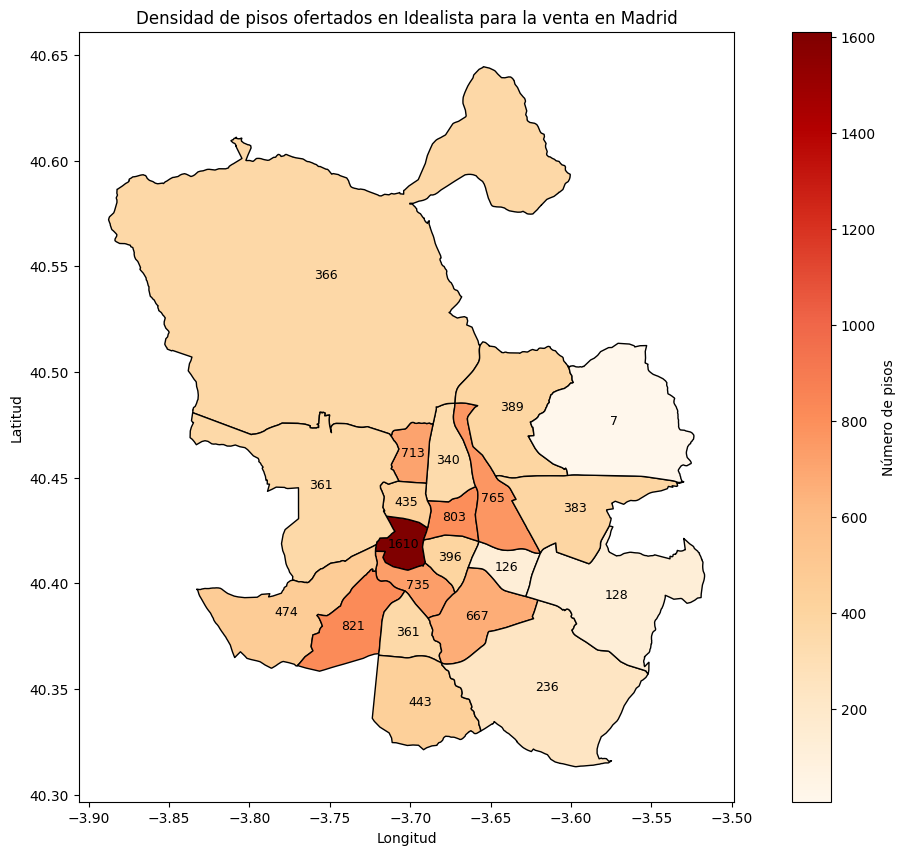

In [10]:
import matplotlib.pyplot as plt

# Asegura que el conteo de puntos por distrito está hecho y almacenado en 'count'

# Une el conteo al GeoDataFrame de distritos
# Convierte 'count' a un DataFrame para facilitar la unión
count_df = count.reset_index()
count_df.columns = ['name', 'points_count']
madrid_districts_with_count = madrid_districts.merge(count_df, on='name', how='left')

# Asegúrate de que cada distrito tenga al menos un valor (0 donde no haya puntos)
madrid_districts_with_count['points_count'] = madrid_districts_with_count['points_count'].fillna(0)

# Crea el "mapa de calor" con líneas más gruesas y muestra los ejes de coordenadas
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
madrid_districts_with_count.plot(column='points_count', ax=ax, legend=True,
                                 legend_kwds={'label': "Número de pisos"},
                                 cmap='OrRd', edgecolor='black', linewidth=1)

# Añade anotaciones con la cantidad de puntos dentro de cada distrito
for idx, row in madrid_districts_with_count.iterrows():
    # Calcula el centroide de cada polígono/distrito
    centroid = row['geometry'].centroid
    # Usa el conteo de puntos como texto de la anotación
    ax.annotate(text=row['points_count'], xy=(centroid.x, centroid.y),
                ha='center', va='center', fontsize=9)

ax.set_title('Densidad de pisos ofertados en Idealista para la venta en Madrid')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.tick_params(axis='both', which='major', labelsize=10)

plt.show()

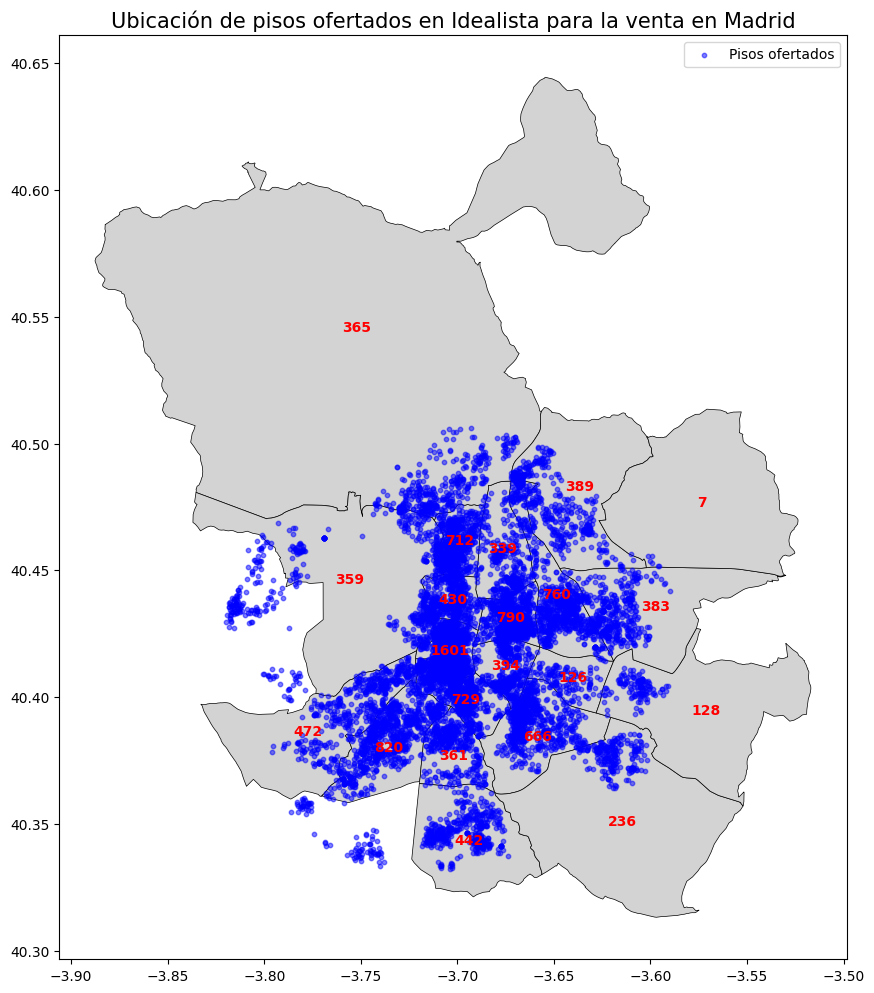

In [7]:
import matplotlib.pyplot as plt

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 12))  # Ajusta el tamaño según necesites

# Dibujar los distritos de Madrid
madrid_districts.plot(ax=ax, color='lightgray', edgecolor='black', alpha=1, linewidth=0.5)

# Dibujar los puntos con mayor transparencia
df_geo.plot(ax=ax, markersize=10, color='blue', alpha=0.5, label='Pisos ofertados')

# Añadir anotaciones con el conteo de puntos por distrito
for idx, row in madrid_districts_with_count.iterrows():
    # Calcular el centroide de cada polígono/distrito
    centroid = row['geometry'].centroid
    # Usar el conteo de puntos como texto de la anotación
    ax.annotate(text=row['points_count'], xy=(centroid.x, centroid.y),
                ha='center', va='center', fontsize=10, color='red', fontweight='bold')

# Añadir título y leyenda
ax.set_title("Ubicación de pisos ofertados en Idealista para la venta en Madrid", fontsize=15)
ax.legend()


# Mostrar el gráfico
plt.show()
